# Data preparation

Miembros del grupo:
- Pablo Carmona
- Javier Sendra

In [1]:
# We will use pandas, a very widespread library in python
# In case you have never used it, or want to review its documentation
# These are some interesting docs:
# http://pandas.pydata.org/pandas-docs/stable/
# https://pandas.pydata.org/pandas-docs/stable/getting_started/tutorials.html
# https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html
# https://pandas.pydata.org/pandas-docs/stable/user_guide/cookbook.html
import pandas as pd
%matplotlib inline

### read data

In [34]:
# read_csv is the function that reads csvs, it returns a Pandas dataframe
df = pd.read_csv('/workspaces/Credit_risk/prosperLoanData.csv',quoting=False)

In [3]:
# Check number of rows and columns
print ('The DataSet has {} rows and {} columns'.format(df.shape[0], df.shape[1]))

The DataSet has 113937 rows and 81 columns


In [4]:
# Check the columns name
df.columns

Index(['ListingKey', 'ListingNumber', 'ListingCreationDate', 'CreditGrade',
       'Term', 'LoanStatus', 'ClosedDate', 'BorrowerAPR', 'BorrowerRate',
       'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss',
       'EstimatedReturn', 'ProsperRating (numeric)', 'ProsperRating (Alpha)',
       'ProsperScore', 'ListingCategory (numeric)', 'BorrowerState',
       'Occupation', 'EmploymentStatus', 'EmploymentStatusDuration',
       'IsBorrowerHomeowner', 'CurrentlyInGroup', 'GroupKey',
       'DateCreditPulled', 'CreditScoreRangeLower', 'CreditScoreRangeUpper',
       'FirstRecordedCreditLine', 'CurrentCreditLines', 'OpenCreditLines',
       'TotalCreditLinespast7years', 'OpenRevolvingAccounts',
       'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries',
       'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
       'RevolvingCreditBalance', 'BankcardUtilization',
       'Availa

Algunas de las columnas claves del dataset son:

- **LoanStatus**: Esta variable representa el estado acual del prestamo. Puede tener las siguientes categorías: 'Cancelled', 'Chargedoff', 'Completed', 'Current', 'Default', 'FinalPaymentInProgress' y 'PastDue'. Hay que destacar que este último vendrá acompañado de un 'Delicuency bucket'


- **LoanMonthsSinceOrigination**: Esta variable representa el número de meses transcurridos desde la fecha de originación.


- **LoanFirstDefaultedCycleNumber**: Esta variable representa el ciclo del préstamo hasta que incurrió en Default.


- **LoanCurrentDaysDelinquent**: Esta variable representa el número de días en las que el préstamo incurrío en mora


# Performance & Sample Window

<Axes: >

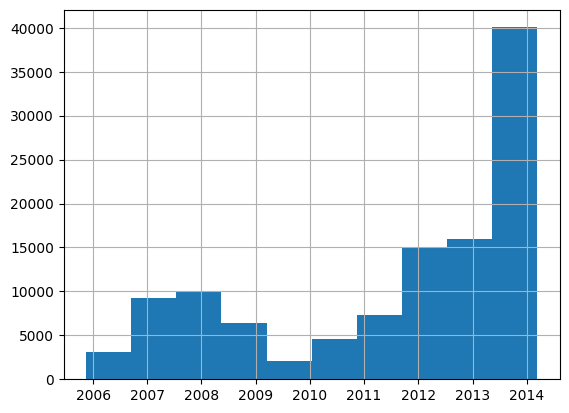

In [5]:
pd.to_datetime(df.LoanOriginationDate.str[:10]).hist()

**TODO 1** Seleccionar y razonar la columna que debería ser usada como input para nuestra variable objetivo. Existen dos opciones:
- Opción A: **LoanStatus** 
- Opción B: **LoanFirstDefaultedCycleNumber** 

Escribe tu respuesta aquí:

Nuestra varaible objetivo cambiara dependiendo de el objetivo del analisis, si quisiesemos observar el numero actual de prestamos que han sido cancelados o 'Defulted' en relacion a cierta vraiable, la princial sera LoanStatus. 
En caso contrario, en el cual el objetivo sea predecir o adelantar cuando basandonos en datos historicos. el prestamo entrara en Default, entonces LoanFirstDefaultedCycleNumber sera la variable principal.

## Vintage analysis

El análisis Vintage nos permite entender el comportamiento de los prestamos con respecto al bad rate, para cada año de origen del préstamo, y para cada ventana en la que evaluamos si ha habido default.

In [35]:
# Years since loan origination
df['LoanMonthsSinceOriginationY'] = (df.LoanMonthsSinceOrigination / 12).round()
# Quarter in which the Loan defaulted
df['LoanFirstDefaultedCycleNumberQ'] = 4 * (df.LoanFirstDefaultedCycleNumber / 4).round()
# Get the number of loans per origination year
df_vintage = df.groupby('LoanMonthsSinceOriginationY').agg({'LoanMonthsSinceOriginationY': 'size'})\
                                                     .rename(columns={'LoanMonthsSinceOriginationY': 'N_loans'})\
                                                     .reset_index()


# For each year, compute the cummulative sum of defaulted loans per quarter
df['bad_aux'] = ~df['LoanFirstDefaultedCycleNumber'].isna()
df_def_per_cycle = pd.DataFrame(df.groupby(['LoanMonthsSinceOriginationY', 'LoanFirstDefaultedCycleNumberQ'])['bad_aux'].sum().groupby(level=[0]).cumsum()).reset_index()
df_def_per_cycle.columns = df_def_per_cycle.columns[:-1].tolist() +  ['N_bads']

# Merge both data sources, compute the bad rate
df_vintage = df_vintage.merge(df_def_per_cycle, on='LoanMonthsSinceOriginationY')
df_vintage['BR'] = 100. * df_vintage['N_bads'] / df_vintage['N_loans']

df_vintage[df_vintage.LoanMonthsSinceOriginationY==7]

,LoanMonthsSinceOriginationY,N_loans,LoanFirstDefaultedCycleNumberQ,N_bads,BR
60,7.0,10513,0.0,209,1.988015
61,7.0,10513,4.0,302,2.872634
62,7.0,10513,8.0,1398,13.297822
63,7.0,10513,12.0,1978,18.814801
64,7.0,10513,16.0,2659,25.292495
65,7.0,10513,20.0,3013,28.659755
66,7.0,10513,24.0,3508,33.368211
67,7.0,10513,28.0,3754,35.708171
68,7.0,10513,32.0,4075,38.761533
69,7.0,10513,36.0,4207,40.017122


In [36]:
# Transform from long to wide format
df_vin_pvt = df_vintage.pivot(index='LoanMonthsSinceOriginationY', columns='LoanFirstDefaultedCycleNumberQ', values='BR')
df_vin_pvt

LoanFirstDefaultedCycleNumberQ,0.0,4.0,8.0,12.0,16.0,20.0,24.0,28.0,32.0,36.0,40.0,44.0
LoanMonthsSinceOriginationY,,,,,,,,,,,,
0.0,NaN,0.003355,0.010064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.0,0.014195,0.085171,2.186051,2.943125,3.368979,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,0.039757,0.462181,5.342411,8.180101,12.160819,13.850512,15.132691,15.321539,15.326508,NaN,NaN,NaN
3.0,0.497830,0.931836,5.731427,8.424815,12.215982,14.003064,16.504978,17.870820,19.019658,19.211131,19.223896,NaN
4.0,1.117222,1.460983,4.417326,6.170505,8.765899,10.072190,12.220694,13.234789,14.575455,15.177037,15.830182,NaN
5.0,0.861009,NaN,6.150062,9.963100,14.022140,15.252153,17.958180,19.311193,20.541205,21.156212,22.017220,NaN
6.0,1.280445,1.851079,8.427279,12.985386,20.215727,23.291580,27.446068,29.485038,31.649269,32.713987,34.036186,34.043145
7.0,1.988015,2.872634,13.297822,18.814801,25.292495,28.659755,33.368211,35.708171,38.761533,40.017122,41.396366,NaN
8.0,1.276596,2.723404,11.177305,15.829787,22.978723,25.929078,29.900709,31.659574,34.269504,35.659574,36.964539,NaN


<Axes: xlabel='LoanFirstDefaultedCycleNumberQ'>

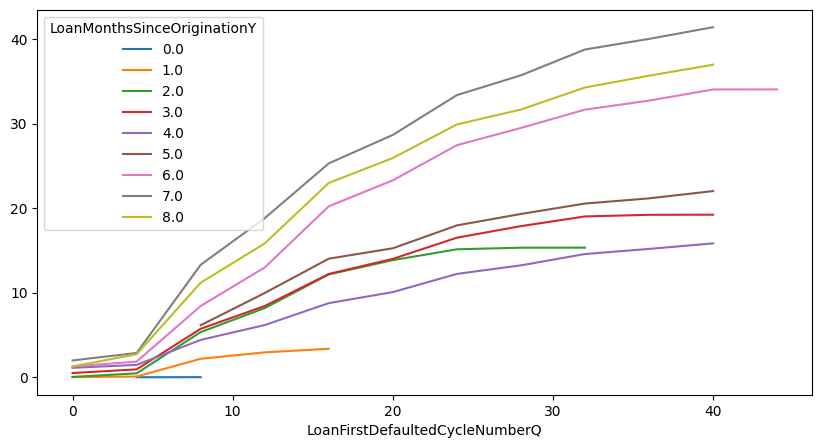

In [37]:
df_vin_pvt.transpose().plot(figsize=(10, 5))

**TODO 2** Explica qué aprendizajes se pueden leer en la gráfica anterior. Razona si los prestamos originados hace 7 años tienen un comportamiento parecido o diferente con respecto a los prestamos originados hace 3 años.

Escribe tu respuesta aquí:

Observando las diferencias entre lps dos prestamos, vemos como hay un mayor incremento de el BadRate durante el segundo ciclo de cuartos en los prestamos de 7Y con respect los prestamos originados hace 3Y.  La diferencia entre ambos va incrementando a medida que el DefaultedCycle incrementa, a pesar de ello como podemos observar en la **tabla TD2**.

El comportamiento del prestamo 7Y tiene un crecimiento continuo, aunque se va estabilizando a medida que los ciclos de cuartos van incrementado, este comportamiento se comparte con la mayoria de prestamos. 

En cuanto al prestamo 3Y tiene un crecimiento menor y se estabiliza sobre el ciclo de los quartos 30.

Esto demuestra como los prestamos han mejorado su eficacia y la evaluacion crediticia de los bancos ha mejorado, ya que BR decrecen a medida que el origen de los prestamos es menor. 

In [9]:
a = df_vintage[df_vintage.LoanMonthsSinceOriginationY==7].BR.reset_index().drop('index',axis=1)
b = df_vintage[df_vintage.LoanMonthsSinceOriginationY==3].BR.reset_index().drop('index',axis=1)
TD2 = a-b

In [10]:
TD2

,BR
0,1.490185
1,1.940798
2,7.566395
3,10.389986
4,13.076513
5,14.656691
6,16.863232
7,17.837351
8,19.741875
9,20.805991


## Good, bad, indeterminate definition

**TODO 3** Implementa una función, que añada las siguientes columnas a nuestro dataframe df:
- **PW**: Captura si el préstamo tiene una madurez(LoanMonthsSinceOrigination) mayor que la PW (Performance window). La variable de entrada PW_size captura el número de meses de la PW.
- **fraud.**: Captura si el préstamo puede considerarse como un caso de fraude. En nuestro caso, consideramos fraude los préstamos que hayan tenido un evento de impago antes de TH_fraud.
- **bad.**: Captura si el préstamo cumple la condición de malo. En nuestro caso, que el evento de impago haya ocurrido después de TH_fraud, y antes del final de la PW
- **indeterm**: Captura si el préstamo se considera indeterminado. Definiremos indeterminados aquellos prestamos que han caído en impago después de la Performance window

In [38]:
# Use fraud threshold = 4 months
# PW sera de 12 meses

def generate_pop_flags(df, PW_size, TH_fraud=4):
    """Generates fraud, bad, and indeterminate columns
    
    Args:
        df: Pandas DataFrame with the input data
        PW_size: Int Performance window size (months)
        TH_fraud: Int number of months used as treshold for fraud
        
    Returns:
        Pandas DataFrame with the columns that capture
        PW, fraud, bad and indeterminate
    """
    ## Implement the function HERE ##
    PW = []
    for x in df.LoanMonthsSinceOrigination:
         if x > PW_size:
              PW.append(True)
         else:
              PW.append(False)
    df['PW'] = PW
    Fraud = []
    for x in df.LoanFirstDefaultedCycleNumber:
          if x < TH_fraud and x != 0:
                Fraud.append(True)
          else: 
            Fraud.append(False)
    df['fraud'] = Fraud
    Bad = []
    for x in df.LoanFirstDefaultedCycleNumber:
          if x > TH_fraud and x < PW_size:
                Bad.append(True)
          else: 
            Bad.append(False)
    df['bad'] = Bad
    Indeterm = []
    for x in df.LoanFirstDefaultedCycleNumber:
          if x > PW_size:
                Indeterm.append(True)
          else: 
            Indeterm.append(False)
    df['indeterm'] = Indeterm    
    return df

def get_volume_y_ratio_DF(df):
      a = pd.DataFrame(columns=['Volumen de Prestamos Maduros', 'Ratio de Prestamos Maduros',
                                'Volumen de Prestamos Fraudulentos', 'Ratio de Prestamos Fraudulentos',
                                'Volumen de Prestamos Bad', 'Ratio de Prestamos Bad',
                                'Volumen de Prestamos Indeterminados', 'Ratio de Prestamos Indeterminados'])
      a['Volumen de Prestamos Maduros'] = df.PW.value_counts()
      a['Ratio de Prestamos Maduros'] = df.PW.value_counts()/len(df)
      a['Volumen de Prestamos Fraudulentos'] = df.fraud.value_counts()
      a['Ratio de Prestamos Fraudulentos'] = df.fraud.value_counts()/len(df)
      a['Volumen de Prestamos Bad'] = df.bad.value_counts()
      a['Ratio de Prestamos Bad'] = df.bad.value_counts()/len(df)
      a['Volumen de Prestamos Indeterminados'] = df.indeterm.value_counts()
      a['Ratio de Prestamos Indeterminados'] = df.indeterm.value_counts()/len(df)
      return a

**TODO 4** Para diferentes PW_size (se recomiendan evaluar los siguientes valores: 6, 9, 12, 15 y 18), evalúa el volumen y ratio de prestamos con madurez, prestamos fraudulentos, prestamos que cumplan la definición de bad, y préstamos que se consideren indeterminados. Por último, argumenta cuál es el valor de PW_size que se debería usar. La función se debe usar con el valor por defecto de  TH_fraud=4

In [39]:
# Test different PW_size values here
# Probamos con el varios valores
#PW_size = 6
df6 = generate_pop_flags(df,6)
get_volume_y_ratio_DF(df6)


,Volumen de Prestamos Maduros,Ratio de Prestamos Maduros,Volumen de Prestamos Fraudulentos,Ratio de Prestamos Fraudulentos,Volumen de Prestamos Bad,Ratio de Prestamos Bad,Volumen de Prestamos Indeterminados,Ratio de Prestamos Indeterminados
PW,,,,,,,,
True,84129,0.738382,490,0.004301,379,0.003326,15294,0.134232
False,29808,0.261618,113447,0.995699,113558,0.996674,98643,0.865768


In [40]:
#PW_size = 9
df9 = generate_pop_flags(df,9)
get_volume_y_ratio_DF(df9)

,Volumen de Prestamos Maduros,Ratio de Prestamos Maduros,Volumen de Prestamos Fraudulentos,Ratio de Prestamos Fraudulentos,Volumen de Prestamos Bad,Ratio de Prestamos Bad,Volumen de Prestamos Indeterminados,Ratio de Prestamos Indeterminados
PW,,,,,,,,
True,75441,0.662129,490,0.004301,2930,0.025716,12549,0.11014
False,38496,0.337871,113447,0.995699,111007,0.974284,101388,0.88986


In [42]:
#PW_size = 12
df12 = generate_pop_flags(df,12)
get_volume_y_ratio_DF(df12)

,Volumen de Prestamos Maduros,Ratio de Prestamos Maduros,Volumen de Prestamos Fraudulentos,Ratio de Prestamos Fraudulentos,Volumen de Prestamos Bad,Ratio de Prestamos Bad,Volumen de Prestamos Indeterminados,Ratio de Prestamos Indeterminados
PW,,,,,,,,
True,69522,0.610179,490,0.004301,5600,0.04915,9993,0.087706
False,44415,0.389821,113447,0.995699,108337,0.95085,103944,0.912294


In [15]:
#PW_size = 15
df15 = generate_pop_flags(df,15)
get_volume_y_ratio_DF(df15)

,Volumen de Prestamos Maduros,Ratio de Prestamos Maduros,Volumen de Prestamos Fraudulentos,Ratio de Prestamos Fraudulentos,Volumen de Prestamos Bad,Ratio de Prestamos Bad,Volumen de Prestamos Indeterminados,Ratio de Prestamos Indeterminados
PW,,,,,,,,
True,66218,0.581181,490,0.004301,7928,0.069582,7764,0.068143
False,47719,0.418819,113447,0.995699,106009,0.930418,106173,0.931857


In [16]:
#PW_size = 18
df18 = generate_pop_flags(df,18)
get_volume_y_ratio_DF(df18)

,Volumen de Prestamos Maduros,Ratio de Prestamos Maduros,Volumen de Prestamos Fraudulentos,Ratio de Prestamos Fraudulentos,Volumen de Prestamos Bad,Ratio de Prestamos Bad,Volumen de Prestamos Indeterminados,Ratio de Prestamos Indeterminados
PW,,,,,,,,
True,61143,0.536639,490,0.004301,9980,0.087592,5835,0.051213
False,52794,0.463361,113447,0.995699,103957,0.912408,108102,0.948787


Un vez observados los Dataset

In [43]:
PW_size = 12
df = generate_pop_flags(df, PW_size)

Tras analizar los distintos sizes determinados por el ejercicio, coincidimos en que el valor mejor es el Power Window mas pequeña ya que el numero de prestamos maduros incrementa, los prestamos BAD decrecen y los indeterminados incrementa también. Al incrementar los indeterminados no significa estrictamente una perdida.

## First exclusion set

**TODO 5** Implementa una función que ejecutará las exclusiones a nuestro dataframe. La función debe excluir los siguientes préstamos:
- Préstamos que tengan una madurez menor que la PW
- Préstamos que se consideren como fraude
    

In [44]:
"""Function that handles the population definition
    
    Args:
        df: Pandas DataFrame with the in time input data
        
    Returns:
        Pandas DataFrame with the population definition applied
    """
    ## Implement the function HERE ##
def filter_exclusions(df, PW_size, TH_fraud=4):
    df = df[df['PW'] & df['fraud'] == False]
    return df

In [45]:
df = filter_exclusions(df,12)
print ('The DataSet has {} rows and {} columns'.format(df.shape[0], df.shape[1]))

The DataSet has 113448 rows and 88 columns


## Bad rate

In [255]:
df.bad.value_counts()

bad
False    86446
True       379
Name: count, dtype: int64

In [256]:
100. * df.bad.value_counts() / df.shape[0]

bad
False    99.56349
True      0.43651
Name: count, dtype: float64

In [257]:
df[['ListingCreationDate', 'LoanOriginationDate']].head()

,ListingCreationDate,LoanOriginationDate
0,2007-08-26 19:09:29.263000000,2007-09-12 00:00:00
2,2007-01-05 15:00:47.090000000,2007-01-17 00:00:00
3,2012-10-22 11:02:35.010000000,2012-11-01 00:00:00
4,2013-09-14 18:38:39.097000000,2013-09-20 00:00:00
6,2013-04-12 09:52:56.147000000,2013-04-18 00:00:00


In [258]:
df['LoanOriginationDate'] = pd.to_datetime(df.LoanOriginationDate.str[:10])
df['LoanOriginationYear'] = pd.to_datetime(df.LoanOriginationDate.values).year

## Additional exclusions

Una vez aplicadas las exclusiones anteriores, vamos a estudiar la tasa de malos por año de origen del préstamo.

**TODO 6** Implementa una función agregue los préstamos por año (LoanOriginationYear), y compute el número de prestamos, el número de "malos" y la tasa de malos.

In [259]:
def describe_yearly_BR(df, col_year, col_target):
    """Describes the yearly number of loans, bad loans and bad rate of the portfolio
    
    Args:
        df: Pandas DataFrame with the input data
        col_year: Name of the column that captures the loan origination date
        col_target: Name of the target column
        
    Returns:
        Pandas DataFrame with the yearly number of loans, bad 
        loans and bad rate of the portfolio 
    """
    ## Implement the function HERE ##
    new_df = pd.DataFrame()
    new_df['Yearly_total_number']= df.groupby([col_year])[col_target].agg('count')
    new_df['Yearly_total_bad'] = df[df[col_target]==True].groupby(col_year)[col_target].agg('count')
    new_df['Ratio_bad'] = round(new_df['Yearly_total_bad']/new_df['Yearly_total_number'],4)
    return new_df

In [260]:
col_year = 'LoanOriginationYear'
col_target = 'bad'
describe_yearly_BR(df, col_year, col_target)

,Yearly_total_number,Yearly_total_bad,Ratio_bad
LoanOriginationYear,,,
2005,22,NaN,NaN
2006,5842,66.0,0.0113
2007,11287,99.0,0.0088
2008,11414,61.0,0.0053
2009,2033,4.0,0.0020
2010,5579,15.0,0.0027
2011,11208,46.0,0.0041
2012,19546,74.0,0.0038
2013,19894,14.0,0.0007


**TODO 7** Usando los resultados obtenidos por la función describe_yearly_BR, define cuál será la Sample Window (qué años se consideraran para capturar préstamos en la población). La Sample Window debe de cumplir las siguientes condiciones: 
- Debe de tener un ratio de positivos (malos, en nuestro caso) aproximadamente constante
- Debe de capturar un periodo que en principio debería representar el entorno en que se usará el modelo
- Debe de capturar un periodo lo más reciente posible

Define también qué periodo temporal capturará la muestra IT (In Time), y la muestra OOT (Out of time).

Escribe tu respuesta aquí:
En nuestro caso hemos escogido la Sample Window entre las fechas entre 2009 y 2012, ya que el ratio bad se mantiene bastante constante y es de los datos mas recientes que tenemos. El resto sera Out of time 

### Final output sampling:

   

 - IT (In Time):
     - Train
     - Validation 
     - Reject Inference sample
 - OOT (Out of time)


In [261]:
numbers = []
for number in range(2009,2013):
    numbers.append(number)


In [262]:
numbers = []
for number in range(2009,2013):
    numbers.append(number)
df_it = df[df['LoanOriginationYear'].isin(numbers)]

In [263]:
set(df_it.LoanOriginationYear)

{2009, 2010, 2011, 2012}

In [264]:
numbers = []
for number in range(2009,2013):
    numbers.append(number)
df_it = df[df['LoanOriginationYear'].isin(numbers)]
df_train = df_it.sample(frac=0.6, random_state=42)
df_val_ri = df_it.loc[~df_it.index.isin(df_train.index)]
df_val = df_val_ri.sample(frac=0.5, random_state=42)
df_ri = df_val_ri.loc[~df_val_ri.index.isin(df_val.index)]

In [265]:
df_oot = df[~df['LoanOriginationYear'].isin(numbers)]

In [266]:
len(df_it), len(df_train), len(df_val), len(df_ri), len(df_oot)

(38366, 23020, 7673, 7673, 48459)

In [267]:
# Write everything
#df_train.to_csv('/workspaces/Credit_risk/prosperLoanData_train.csv', index=False)
#df_val.to_csv('/workspaces/Credit_risk/prosperLoanData_val.csv', index=False)
#df_ri.to_csv('/workspaces/Credit_risk/prosperLoanData_ri.csv', index=False)
#df_oot.to_csv('/workspaces/Credit_risk/prosperLoanData_oot.csv', index=False)